# Detailed DDT recovery walkthrough
This tutorial demonstrates in detail the usage of the `Inverter` class to estimate the distribution of diffusion times (DDT, see https://doi.org/10.1103/PhysRevLett.120.116001) from simulated impedance data.

In [85]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook
import glob
from copy import deepcopy

from bayes_drt.inversion import Inverter
from bayes_drt import eis_utils as gt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# set plotting params and data directory
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

# 1. Load simulated data

For this tutorial, we'll use two simulated impedance spectra: one simulated from a transmissive planar DDT and one simulated from a blocking planar DDT. In each case, the true distribution is bimodal, while a small amount of random noise is added to the exact impedance.

In [44]:
"Load transmissive planar data"
# load simulated impedance data with noise
Z_file_tp = os.path.join(datadir,'simulated','Z_BimodalTP-DDT_Orazem_0.25.csv')
Zdf_tp = pd.read_csv(Z_file_tp)

# load true DDT
g_file_tp = os.path.join(datadir,'simulated','gamma_BimodalTP-DDT.csv')
g_tp = pd.read_csv(g_file_tp)

# extract frequency and complex impedance
freq_tp = Zdf_tp['Freq'].values
Z_tp = Zdf_tp['Zreal'].values + 1j*Zdf_tp['Zimag'].values

"Load blocking planar data"
# load simulated impedance data with noise
Z_file_bp = os.path.join(datadir,'simulated','Z_BimodalBP-DDT_Orazem_0.25.csv')
Zdf_bp = pd.read_csv(Z_file_bp)

# load true DDT
g_file_bp = os.path.join(datadir,'simulated','gamma_BimodalBP-DDT.csv')
g_bp = pd.read_csv(g_file_bp)

# extract frequency and complex impedance
freq_bp = Zdf_bp['Freq'].values
Z_bp = Zdf_bp['Zreal'].values + 1j*Zdf_bp['Zimag'].values

<IPython.core.display.Javascript object>


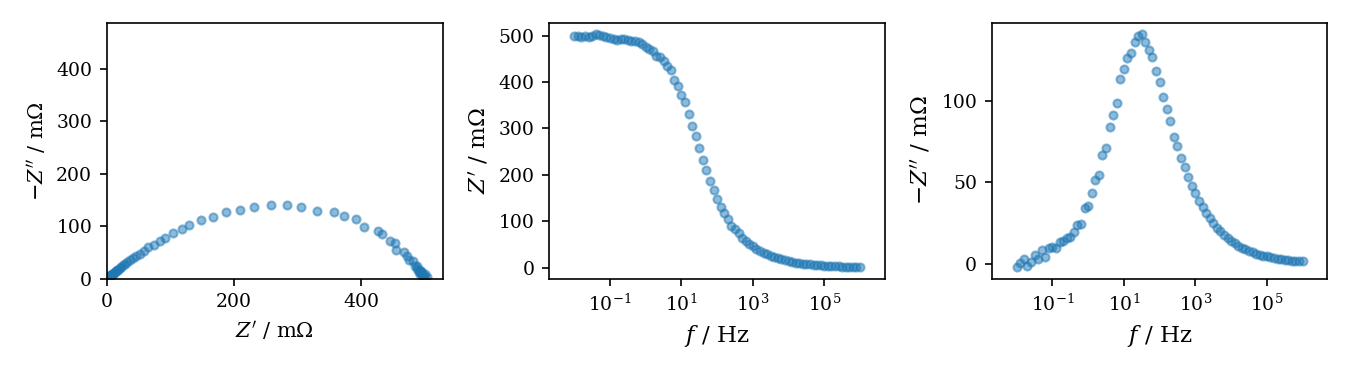

(0, 487.57641406689083)

In [21]:
# plot transmissive planar data
axes = gt.plot_full_eis(Zdf_tp,bode_cols=['Zreal','Zimag'],s=15,alpha=0.5)
axes[0].set_xlim(0,axes[0].get_xlim()[1])
axes[0].set_ylim(0,axes[0].get_ylim()[1])

<IPython.core.display.Javascript object>


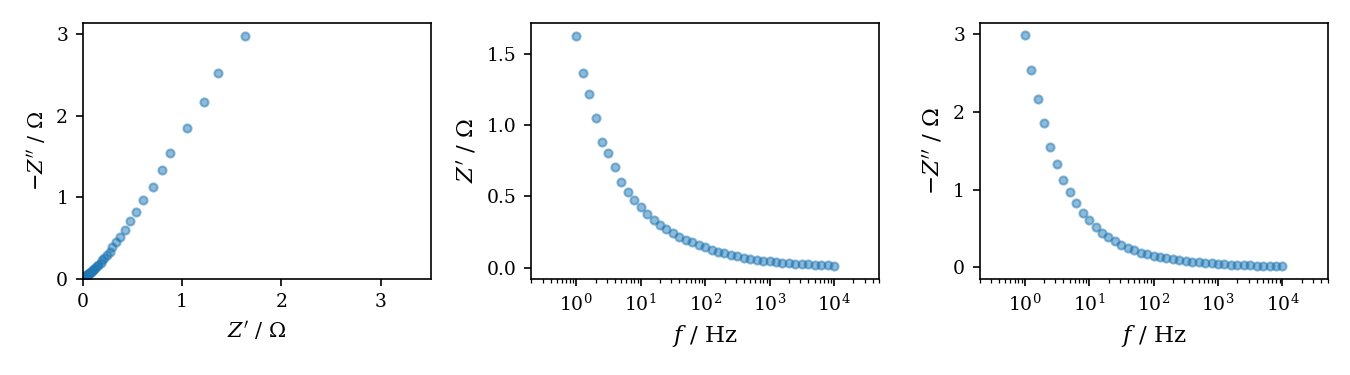

(0, 3.1435435945560903)

In [23]:
# plot blocking planar data
axes = gt.plot_full_eis(Zdf_bp,bode_cols=['Zreal','Zimag'],s=15,alpha=0.5)
axes[0].set_xlim(0,axes[0].get_xlim()[1])
axes[0].set_ylim(0,axes[0].get_ylim()[1])

# 2. Specify the desired distribution

As illustrated in the previous tutorials, the `Inverter` class assumes that we want to fit the DRT unless we specify otherwise. We can indicate that we want to fit a different distribution by providing an argument for the `distributions` paramter when we instantiate an `Inverter` object. The `distributions` argument should be a nested dictionary: at the top level, each key is the (user-supplied) name of a distribution that we want to fit, and the corresponding dictionary value is another dictionary, which defines the properties of the distribution. In this tutorial, we will be fitting a single distribution (either a transmissive planar DDT or a blocking planar DDT), so the top-level dict will have only one key-value pair. The top-level dict should contain multiple key-value pairs *only* when a multi-distribution fit is desired, as described in the multi-distribution recovery tutorial.

The structure of the `distributions` argument is documented in the `set_distributions` method:

In [6]:
help(Inverter.set_distributions)

Help on function set_distributions in module bayes_drt.inversion:

set_distributions(self, distributions)
    Set kernels for inversion
    
    Parameters:
    -----------
    distributions: dict
            Dict of dicts describing distributions to include. Top-level keys are user-supplied names for distributions. 
            Each nested dict defines a distribution and should include the following keys:
                    kernel: 'DRT' or 'DDT'
                    dist_type: 'series' or 'parallel' (default 'parallel'). Valid for DDT only
                    symmetry: 'planar' or 'spherical' (default 'planar'). Valid for DDT only
                    bc: 'transmissive' or 'blocking' (default 'transmissive'). Valid for DDT only
                    ct: boolean indicating whether there is a simultaneous charge transfer reaction (default False). 
                            Valid for DDT only
                    k_ct: apparent 1st-order rate constant for simultaneous charge transfer reac

The five key parameters that we need to supply to define the DDT are `kernel`, `dist_type`, `symmetry`, `bc`, and `ct`, defined below:
* `kernel`: indicates the kernel type ('DRT' or 'DDT')
* `dist_type`: indicates whether the distribution is a series or parallel distribution. If series, the impedance is integrated; if parallel, the admittance is integrated
* `symmetry`: indicates the symmetry/geometry of the system. Current options are 'planar' or 'spherical'
* `bc`: indicates the boundary condition ('transmissive' or 'planar')
* `ct`: indicates whether a simultaneous charge transfer reaction occurs with the diffusion process (True or False, default False). If True, the Gerischer-type variant of the corresponding DDT kernel is used

(The DRT is, by definition, a series distribution, while the `symmetry`, `bc`, and `ct` parameters apply only to the DDT, so none of these need to be specified when fitting the DRT.)

First, we'll set up an `Inverter` instance for the transmissive planar DDT. We'll name the distribution 'TP-DDT', but we could choose any string for the name.

In [14]:
inv_tp = Inverter(distributions={'TP-DDT': # user-defined distribution name
                                         {'kernel':'DDT', # indicates that a DDT-type kernel should be used
                                           'dist_type':'parallel', # indicates that the diffusion paths are in parallel
                                           'symmetry':'planar', # indicates the geometry of the system
                                           'bc':'transmissive', # indicates the boundary condition
                                           'ct':False # indicates no simultaneous charge transfer
                                          }
                                },
                  basis_freq=np.logspace(6,-3,91) # use basis range large enough to capture full DDT
                 )

We can initialize an `Inverter` instance for the blocking planar DDT in the same way (in the code below, we  leave `ct` at its default value of `False`).

In [16]:
inv_bp = Inverter(distributions={'BP-DDT': # user-defined distribution name
                                         {'kernel':'DDT', # indicates that a DDT-type kernel should be used
                                           'dist_type':'parallel', # indicates that the diffusion paths are in parallel
                                           'symmetry':'planar', # indicates the geometry of the system
                                           'bc':'blocking', # indicates the boundary condition
                                          }
                                },
                  basis_freq=np.logspace(6,-3,91) # use basis range large enough to capture full DDT
                 )

If the distribution definition for an existing `Inverter` instance needs to be modified, this can be done by updating or overwriting the `distributions` attribute.

# 3. Fit the data

Once the distribution has been specified, fitting proceeds in the same manner as for the DRT. Please note that the model calibration for fitting the DDT has not been tuned or validated as rigorously as for the DRT. DDT recovery appears to be a more challenging problem than DRT recovery, as reflected in the results shown below (See Section 3.1.3 of https://doi.org/10.1016/j.electacta.2020.137493 for comparison to other DDT recovery methods and a discussion of the challenges of DDT recovery).

In [53]:
# fit transmissive planar DDT data
start = time.time()
inv_tp.bayes_fit(freq_tp,Z_tp)
elapsed = time.time() - start
print('HMC fit time: {:.2f} s'.format(elapsed))

# make a copy of the Inverter object to run the MAP fit
# without overwriting the HMC fit 
inv_tpm = deepcopy(inv_tp)
start = time.time()
inv_tpm.map_fit(freq_tp,Z_tp)
elapsed = time.time() - start
print('MAP fit time: {:.2f} s'.format(elapsed))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


HMC fit time: 123.35 s


C:\Users\jdh10\anaconda3\envs\stan\lib\copy.py:169: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  rv = reductor(4)


MAP fit time: 2.30 s


In [62]:
# fit blocking planar DDT data
start = time.time()
inv_bp.bayes_fit(freq_bp,Z_bp)
elapsed = time.time() - start
print('MAP fit time: {:.2f} s'.format(elapsed))

# make a copy of the Inverter object to run the MAP fit
# without overwriting the HMC fit 
inv_bpm = deepcopy(inv_bp)
start = time.time()
inv_bpm.map_fit(freq_bp,Z_bp)
elapsed = time.time() - start
print('MAP fit time: {:.2f} s'.format(elapsed))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
C:\Users\jdh10\anaconda3\envs\stan\lib\copy.py:169: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  rv = reductor(4)


MAP fit time: 135.98 s
MAP fit time: 1.63 s


# 4. Visualize the results
We use the `predict_Z`, `predict_sigma`, and `predict_distribution` methods to obtain the predicted impedance, error scale, and DDT in the same manner as for DRT fits. Recall that the first argument of the `predict_distribution` method is the name of the desired distribution, which we supply with our chosen distribution names as shown below. We define convenience plotting functions which are analogous to those used for earlier previous DRT tutorials.

In [49]:
# call predict_distribution with distribution name specified
inv_tp.predict_distribution('TP-DDT'), \
inv_bp.predict_distribution('BP-DDT')

(array([1.70509709e-02, 2.92234838e-02, 3.90372225e-02, 4.72488295e-02,
        5.39679612e-02, 5.94877212e-02, 6.41207643e-02, 6.81192878e-02,
        7.16301424e-02, 7.47530263e-02, 7.75779392e-02, 8.02393602e-02,
        8.29234785e-02, 8.57246073e-02, 8.87979083e-02, 9.21942281e-02,
        9.59350034e-02, 1.00145610e-01, 1.04885375e-01, 1.10190433e-01,
        1.16110220e-01, 1.22612386e-01, 1.29601629e-01, 1.36950490e-01,
        1.44383338e-01, 1.51596619e-01, 1.58215243e-01, 1.63801109e-01,
        1.67922136e-01, 1.70124182e-01, 1.70108917e-01, 1.67690824e-01,
        1.63012271e-01, 1.56577177e-01, 1.49128436e-01, 1.41605832e-01,
        1.35145627e-01, 1.31058658e-01, 1.30593371e-01, 1.34879817e-01,
        1.44876787e-01, 1.61288627e-01, 1.84444426e-01, 2.13900489e-01,
        2.47771081e-01, 2.82680810e-01, 3.13677586e-01, 3.35008074e-01,
        3.41692005e-01, 3.31508754e-01, 3.05759051e-01, 2.68550567e-01,
        2.25091189e-01, 1.80458455e-01, 1.39118110e-01, 1.043143

In [36]:
# Convenience functions for visualization
def plot_result(inv,Zdf,g_true,plot_ci=False,c='k',label=None,axes=None,plot_data=True):
    "Plot recovered DDT and impedance fit"
    if axes is None:
        fig, axes = plt.subplots(2,2,figsize=(7.5,6))
    else:
        fig = axes.ravel()[0].get_figure()
    freq = Zdf['Freq'].values
    
    if label is None:
        Z_label = 'Fit'
        g_label = 'Recovered'
    else:
        Z_label = label
        g_label = label
    
    # plot noisy data
    if plot_data:
        gt.plot_full_eis(Zdf,axes=axes.ravel()[:3],alpha=0.4,label='Data',bode_cols=['Zreal','Zimag'],s=20)
    # get fitted impedance from Inverter instance
    Z_pred = inv.predict_Z(freq)
    df_pred = gt.construct_eis_df(freq,Z_pred)
    # plot impedance fit
    gt.plot_full_eis(df_pred,axes=axes.ravel()[:3],alpha=0.8,label=Z_label,bode_cols=['Zreal','Zimag'],
                     c=c,plot_func='plot')

    # plot the true DDT
    if plot_data:
        p = axes[1,1].plot(g_true['tau'],g_true['gamma'],label='True',ls='--')
        # plot data limits
        axes[1,1].axvline(1/(2*np.pi*Zdf['Freq'].min()),ls=':',c='gray',label='Data limits')
        axes[1,1].axvline(1/(2*np.pi*Zdf['Freq'].max()),ls=':',c='gray')
    # get the recovered DDT
    dist_name = list(inv.distributions.keys())[0]
    g_pred = inv.predict_distribution(dist_name,g_true['tau'])
    # plot the recovered DDT
    if plot_ci:
        # plot mean and 95% credibility interval (CI) if HMC sampling used
        g_lo = inv.predict_distribution(dist_name,g_true['tau'],percentile=2.5)
        g_hi = inv.predict_distribution(dist_name,g_true['tau'],percentile=97.5)
        axes[1,1].plot(g_true['tau'],g_pred,c=c,label='Posterior mean',alpha=0.8)
        axes[1,1].fill_between(g_true['tau'],g_lo,g_hi,color=c,label='95% CI',alpha=0.15)
    else:
        # otherwise plot point estimate only
        axes[1,1].plot(g_true['tau'],g_pred,c=c,label=g_label,alpha=0.8)
        
    # plot zero line
    for ax in axes.ravel():
        ax.axhline(0,c='k',lw=0.5,zorder=-10)
        
    axes[1,1].set_xscale('log')
    axes[1,1].set_xlabel(r'$\tau$ / s')
    axes[1,1].set_ylabel(r'$p\,(\ln{\tau})$')
#     axes[1,1].set_ylim(-4.5,2)

    for ax in axes.ravel():
        ax.legend()

    fig.tight_layout()
    return axes

def plot_resid(inv,Zdf):
    "Plot residuals and recovered error scale"
    fig,axes = plt.subplots(1,2,figsize=(7.5,3),sharex=True)
    freq = Zdf['Freq'].values
    Zc = Zdf['Zreal'].values + 1j*Zdf['Zimag'].values
    
    # plot residuals
    Z_pred = inv.predict_Z(freq)
    df_err = gt.construct_eis_df(freq,Z_pred-Zc)
    gt.plot_bode(df_err,axes=axes,cols=['Zreal','Zimag'],alpha=0.4,s=20,label='Residuals',unit_scale='')

    # plot true error scale
    p = axes[0].plot(freq,3*Zdf['sigma_re'],ls='--',label='True $\pm 3\sigma$')
    axes[0].plot(freq,-3*Zdf['sigma_re'],ls='--',c=p[0].get_color())
    axes[1].plot(freq,3*Zdf['sigma_im'],ls='--')
    axes[1].plot(freq,-3*Zdf['sigma_im'],ls='--',c=p[0].get_color())
    
    # plot zero line
    for ax in axes:
        ax.axhline(0,c='k',lw=0.5,zorder=-10)

    # get the recovered error scale
    sigma_re, sigma_im = inv.predict_sigma(freq)
    # plot recovered error scale
    axes[0].fill_between(freq,-3*sigma_re,3*sigma_re,color='k',alpha=0.15,label='Recovered $\pm3\sigma$')
    axes[1].fill_between(freq,-3*sigma_im,3*sigma_im,color='k',alpha=0.15)

    axes[0].legend()
    
    fig.tight_layout()
    return axes

## 4a. Transmissive planar DDT
With the convenience plotting functions defined, we first examine the results obtained for the transmissive planar DDT.

<IPython.core.display.Javascript object>


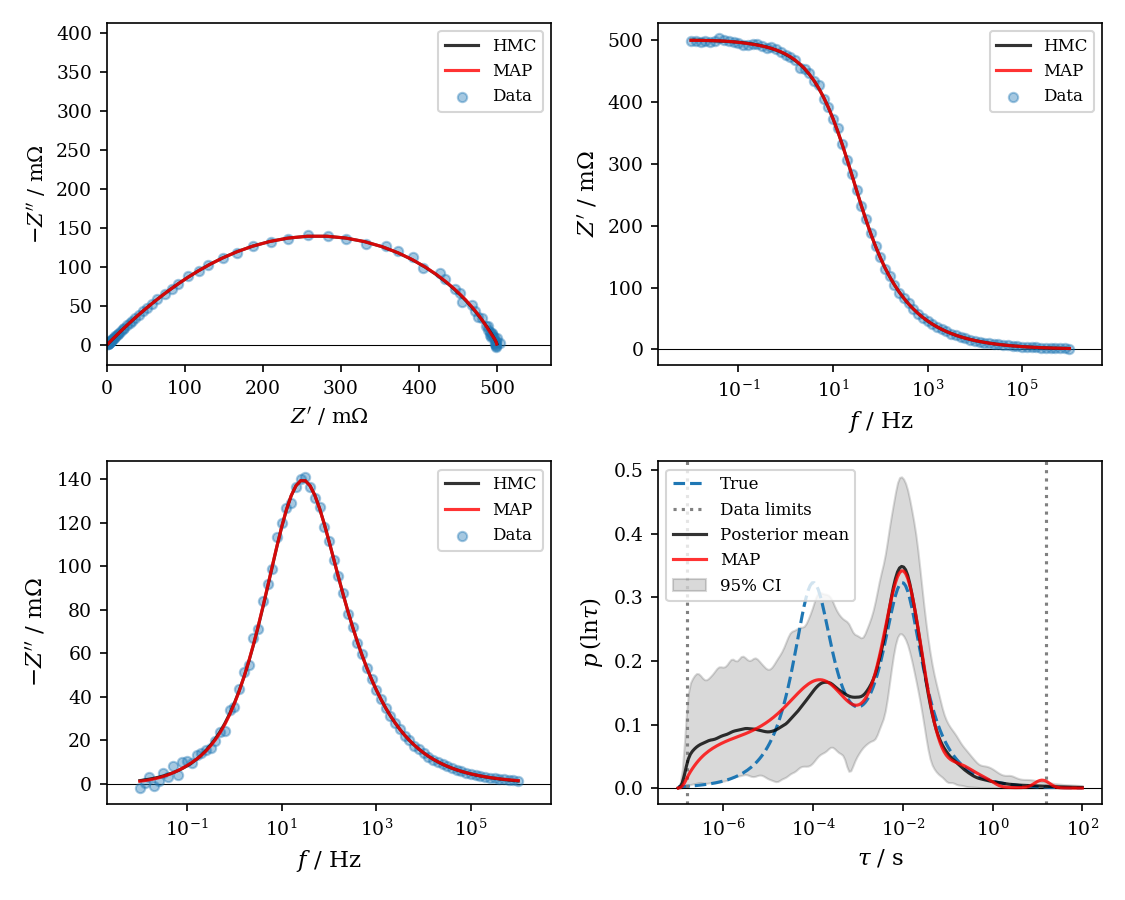

In [59]:
# plot HMC results for transmissive planar DDT
axes = plot_result(inv_tp,Zdf_tp,g_tp,plot_ci=True,label='HMC')
# overlay the MAP results
axes = plot_result(inv_tpm,Zdf_tp,g_tp,plot_data=False,axes=axes,label='MAP',c='r')

The HMC and MAP fits produce similar DDTs and nearly identical fits of the impedance data. The longer timescale DDT peak is captured well by both fits, but the shorter timescale peak is noticeably depressed and dispersed relative to the true peak. The confidence interval is also much wider at shorter timescales. This seems to be common when recovering multimodal DDTs (across DDT recovery algorithms) - features at shorter timescales are more difficult to resolve (see Section 3.1.3 of https://doi.org/10.1016/j.electacta.2020.137493).

Next, let's examine the recovered error structure.

<IPython.core.display.Javascript object>


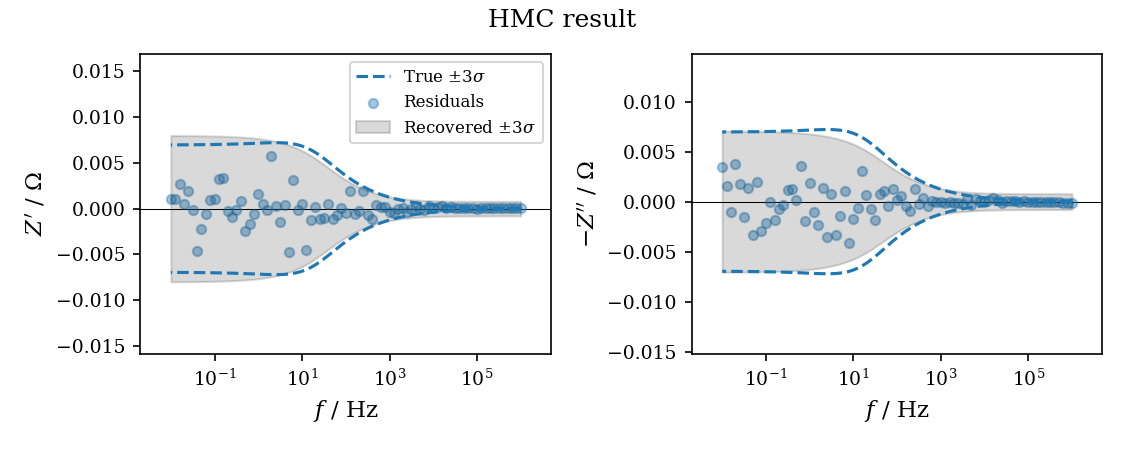

<IPython.core.display.Javascript object>


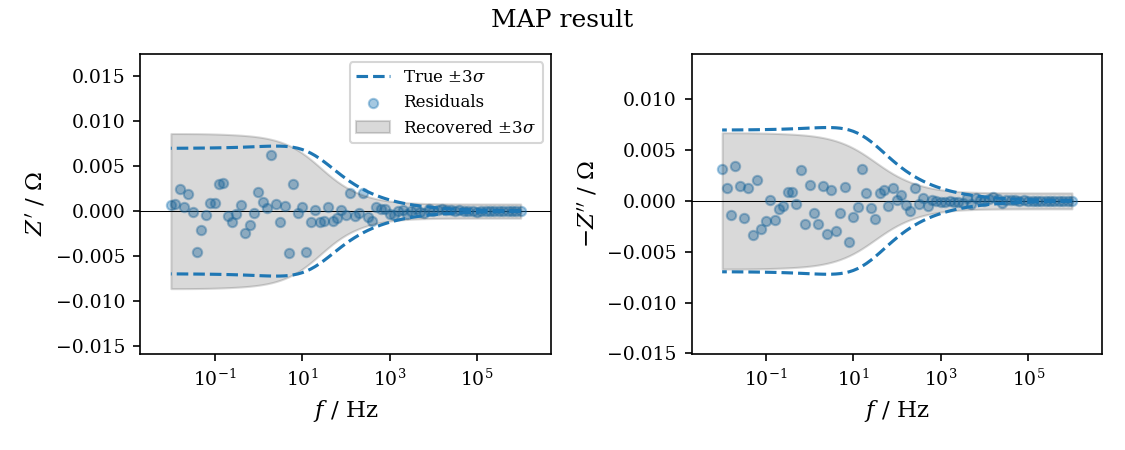

In [68]:
#  plot residuals and error scale for HMC fit
axes1 = plot_resid(inv_tp,Zdf_tp)
fig1 = axes1[0].get_figure()
fig1.suptitle('HMC result')
fig1.subplots_adjust(top=0.88)
#  plot residuals and error scale for MAP fit
axes2 = plot_resid(inv_tpm,Zdf_tp)
fig2 = axes2[0].get_figure()
fig2.suptitle('MAP result')
fig2.subplots_adjust(top=0.88)

The recovered error scales for the HMC and MAP fits are very similar and in fairly good agreement with the true error structure.

The method `predict_Rp` and attributes `R_inf` and `inductance` function in the same manner as for the DRT:

In [80]:
print('Ohmic resistance = {:.5f} ohms'.format(inv_tp.R_inf))
print('Inductance = {:.5e} H'.format(inv_tp.inductance))
print('Polarization resistance = {:.5f} ohms'.format(inv_tp.predict_Rp()))
print('Rp 2.5 percentile = {:.5f} ohms'.format(inv_tp.predict_Rp(percentile=2.5)))
print('Rp 97.5 percentile = {:.5f} ohms'.format(inv_tp.predict_Rp(percentile=97.5)))

Ohmic resistance = 0.00004 ohms
Inductance = 2.28847e-11 H
Polarization resistance = 0.49990 ohms
Rp 2.5 percentile = 0.49839 ohms
Rp 97.5 percentile = 0.50138 ohms


The true values of $R_\infty$, $L$, and $R_p$ are $0 \ \Omega$, $ 0 \ \mathrm{H}$, and $0.5 \ \Omega$, respectively.

## 4b. Blocking planar DDT

Finally, let's look at the results for the blocking planar DDT.

<IPython.core.display.Javascript object>


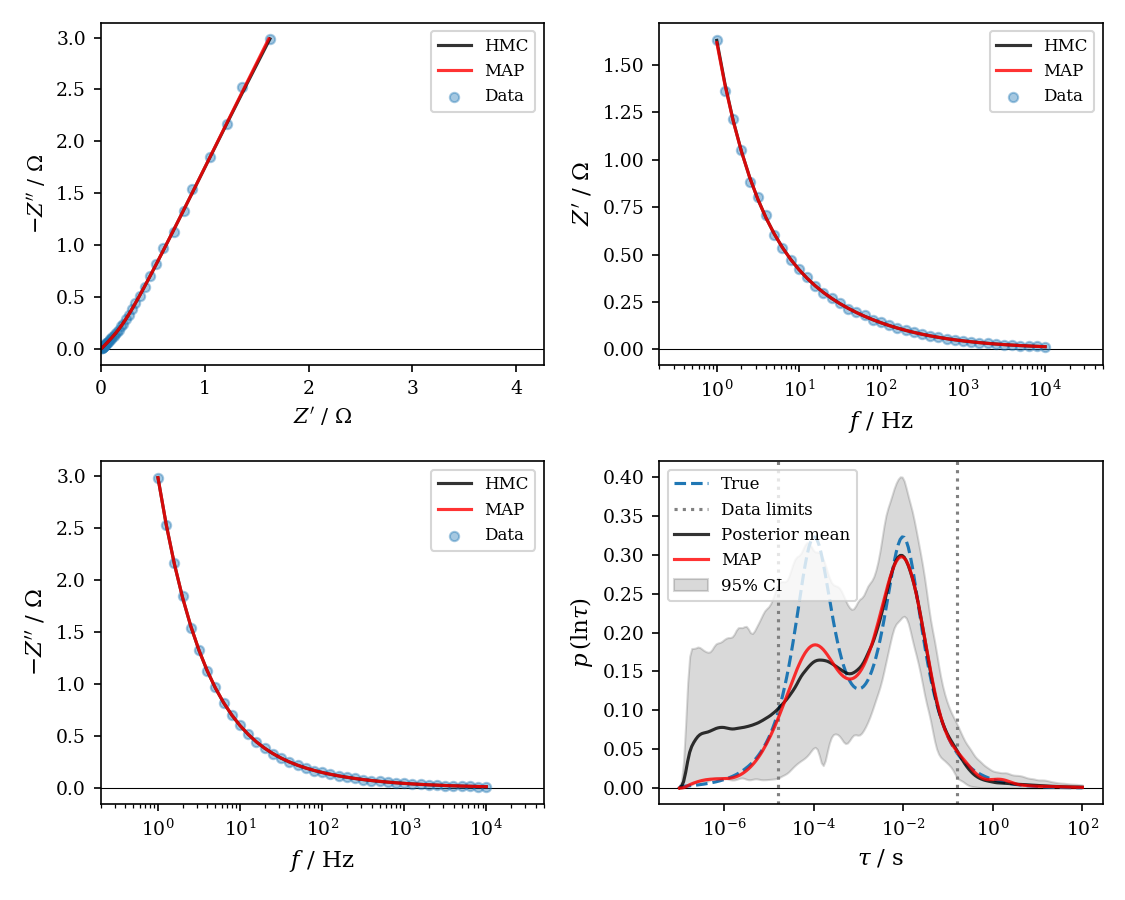

In [63]:
# plot HMC results for blocking planar DDT
axes = plot_result(inv_bp,Zdf_bp,g_bp,plot_ci=True,label='HMC')
# overlay the MAP results
axes = plot_result(inv_bpm,Zdf_bp,g_bp,plot_data=False,axes=axes,label='MAP',c='r')

The results are very similar to those for the transmissive planar DDT - the longer timescale peak is recovered appropriately, while the shorter timescale peak is relatively poorly captured. The HMC fit broadens the shorter timescale peak to a greater extent than the MAP fit.

<IPython.core.display.Javascript object>


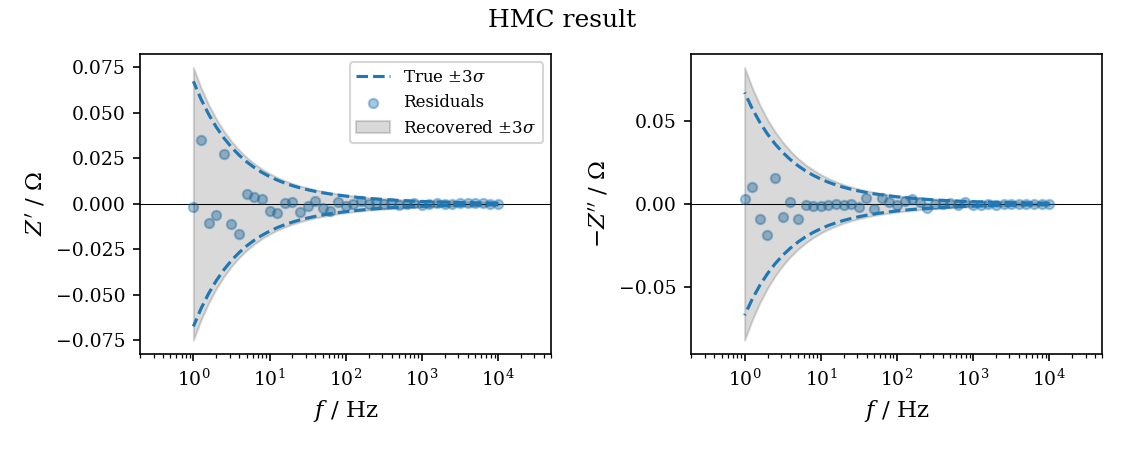

<IPython.core.display.Javascript object>


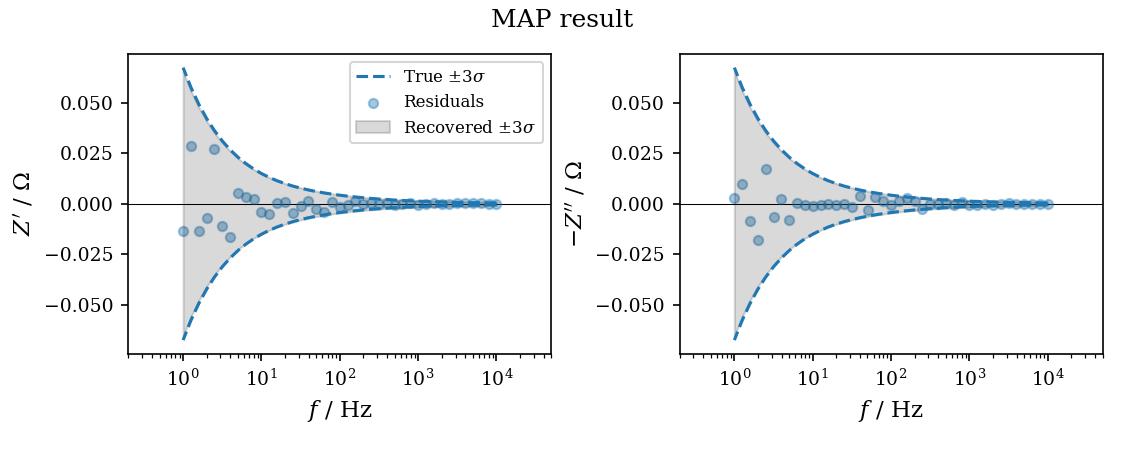

In [67]:
#  plot residuals and error scale for HMC fit
axes1 = plot_resid(inv_bp,Zdf_bp)
fig1 = axes1[0].get_figure()
fig1.suptitle('HMC result')
fig1.subplots_adjust(top=0.88)
#  plot residuals and error scale for MAP fit
axes2 = plot_resid(inv_bpm,Zdf_bp)
fig2 = axes2[0].get_figure()
fig2.suptitle('MAP result')
fig2.subplots_adjust(top=0.88)

The recovered error scales match the true error scale very closely. The HMC fit slightly overestimates the error scale, while the MAP fit produces a nearly perfect estimate of the error scale.

Note that the polarization resistance of a blocking planar DDT is, in theory, infinite. However, the value returned by `predict_Rp` is based on a numerical evaluation of the impedance at very low and very high frequencies and thus returns large but finite values.

In [101]:
print('Ohmic resistance = {:.5f} ohms'.format(inv_bp.R_inf))
print('Inductance = {:.5e} H'.format(inv_bp.inductance))
print('Polarization resistance = {:.5e} ohms'.format(inv_bp.predict_Rp()))
print('Rp 2.5 percentile = {:.5e} ohms'.format(inv_bp.predict_Rp(percentile=2.5)))
print('Rp 97.5 percentile = {:.5e} ohms'.format(inv_bp.predict_Rp(percentile=97.5)))

Ohmic resistance = 0.00006 ohms
Inductance = 2.99280e-09 H
Polarization resistance = 8.04643e+02 ohms
Rp 2.5 percentile = 3.72292e+02 ohms
Rp 97.5 percentile = 1.35367e+03 ohms


c:\users\jdh10\onedrive - colorado school of mines\python\projects\bayes_drt\bayes_drt\inversion.py:2388: RuntimeWarning: overflow encountered in tanh
  return np.tanh(x)/(x - np.tanh(x))


The true values of $R_\infty$ and $L$ are $0 \ \Omega$ and $ 0 \ \mathrm{H}$, respectively.